# EDA and Dataset Loading
#### This notebook will load in the different datasets to be used for the project as well as Exploratory Data Analysis. I start by loading in the necessary libraries for exploratory data anlysis and web scraping.

#### I will then unzip the athlete_events.csv file containing olympic athletes that participated in the Summer Olympic Games for the past 120 years.

#### Then I will begin scraping the results from each track and field event for the 2012 (London) and 2016 (Rio) Summer Games. I will merge the results to the athletes dataframe and be left with one dataframe I can further preprocess and use for modeling.

In [279]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
import requests
from requests import get
import pandas as pd
import numpy as np
import pdfplumber
import tabula
from Olympic_PED_use.src import functions as fn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from bs4 import BeautifulSoup
import certifi
import urllib3
import re
from csv import DictReader, DictWriter

In [281]:
from time import sleep
from random import randint
import requests
from requests import get

In [282]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000000)

In [283]:
from zipfile import ZipFile
zf = ZipFile('../data/athletes_dataset/compressed_athlete_events.zip', 'r')
zf.extractall('../data/athletes_dataset/')
zf.close()

#### Loading in a table showing the amount of annual doping positives per Olympic Game

In [284]:
url = 'https://olympstats.com/2019/01/18/all-olympic-doping-positives-the-count-by-games/'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all(class_= 'table-responsive')    
ped_by_country_df = pd.read_html(str(contents))[0]
ped_by_country_df
ped_by_country_df = ped_by_country_df.drop(22)
ped_by_country_df

,Year,City,###
0,2012.0,London,121
1,2008.0,Beijing,86
2,2000.0,Sydney,42
3,2004.0,Athínai,41
4,2006.0,Torino,19
5,2016.0,Rio de Janeiro,17
6,1996.0,Atlanta,13
7,1984.0,Los Angeles,12
8,2014.0,Sochi,12
9,1976.0,Montréal,11


#### The dataframe above looks to show the number of doping cases in the Olympics  steadily rising since. PED testing didn't become a standard in International Athletic events until the late 90's. This is when the International Olympic Committee led an initiative to create the World Anti-Doping Agency. Knowing this, the data above doesn't necessarily prove that steroid use has been on the rise but possible the testing standards are improving.

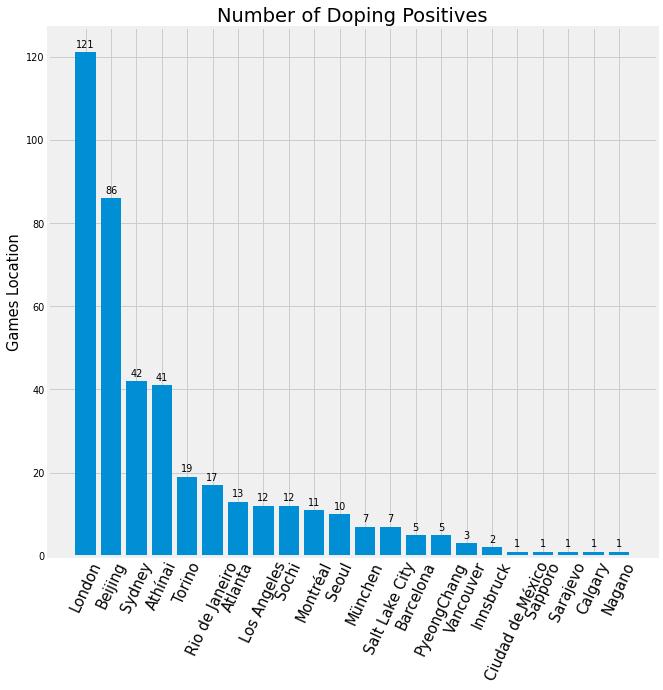

In [285]:
x = ped_by_country_df.City
width = 0.3
labels = ped_by_country_df['City']

fig, ax = plt.subplots(figsize=(10,10), dpi=70)
rect = ax.bar(ped_by_country_df['City'], ped_by_country_df['###'])
ax.set_ylabel('Games Location', fontsize=15)
ax.set_title('Number of Doping Positives', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15, rotation=65)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect)


plt.savefig('../reports/figures/doping_by_games.png', bbox_inches='tight', transparent=True)
plt.show();

#### Retrieving contents of doping cases in athletics Wikipedia page

In [286]:
url = 'https://en.wikipedia.org/wiki/List_of_doping_cases_in_athletics'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all('table', class_='wikitable sortable')   

#### Formatting the values in the dataframe by removing '\n' 

In [287]:
def content_cleaner(df):
    df = df.dropna(axis=0)
    df['rank'] = [x.strip('\n') for x in df['rank']]
    df['rank'] = [x.replace('G', '1.') for x in df['rank']]
    df['rank'] = [x.replace('S', '2.') for x in df['rank']]
    df['rank'] = [x.replace('B', '3.') for x in df['rank']]
    
    df['name'] = [x.strip('\n\n\n\n\n\n\n\n\n\n\n\n') for x in df['name']]
    df['name'] = [x.replace('\n', ' ') for x in df['name']]
    df['name'] = [x[:-3] for x in df['name']]
    df['name'] = [x.lower() for x in df['name']]
    df['name'] = [x.replace('-', ' ') for x in df['name']]
    names = []
    for x in df.name:
        split = x.split()
        x = split[0] + ' ' + split[-1]
        names.append(x)
    df.name = [x for x in names]

    df['result'] = [x[:-4] for x in df['result']]
    df['result'] = [x.split('\r\n') for x in df['result']]
    df['result'] = [x[1] for x in df['result']]
    df['result'] = [x.replace('h', ':') for x in df['result']]
    
    return df


#### Creating doping dataframe and adding a 'flagged' column specifying whether or not the athlete has tested positive for PED use during the Games.

In [288]:
doping = fn.wiki_scraper(contents)

doping = fn.col_format(doping)

doping['flagged'] = [1 for x in doping.index]

In [289]:
doping

,name,country,event,date_of_violation,substance,sanction,references,flagged
0,Nunu Abashidze,Soviet Union,Shot put,1981,,,[1][2],1
1,Ahmed Abd El Raouf,Egypt,Hammer throw,2008,Norandrosterone,2 years,[3][4],1
2,Inga Abitova,Russia,Long distance,2009,Biological passport anomalies,2 years,[5][6][7],1
3,Folashade Abugan,Nigeria,Sprinting,2010,Testosterone prohormone,2 years,[8][9][10],1
4,Ibrahim Mohamed Aden,Somalia,Middle distance,1999,Ephedrine,Public warning,[11][12][13],1
...,...,...,...,...,...,...,...,...
14482,Zhou Wei,China,Sprinting,2000,,2 years,[264],1
14483,Zohar Zimro,Israel,Marathon,2012,,Public reprimand,[219],1
14484,Yevgeniya Zinurova,Russia,Middle distance,2010,Biological passport abnormalities,2 years,[516],1
14485,Khalid Zoubaa,France,Long distance,2007,EPO,3 years,[887],1


#### Reading in the Athlete events csv file containing Olympic athletes and general information

In [290]:
athlete_df = pd.read_csv('../data/athletes_dataset/athlete_events.csv')
athlete_df.columns = [x.lower() for x in athlete_df.columns]

#### Merging the athlete and doping dataframes by name

In [291]:
df = pd.merge(athlete_df, doping, on='name', how='left')
df = df.drop(['sanction', 'references', 'country', 'date_of_violation', 'games'], axis=1)
df = df[df['sport']=='Athletics']
df = df[df['year'] > 2003]
df = df[df['year'] < 2017]


In [292]:
flagged = pd.pivot_table(df, index=['event_x'], values='flagged', aggfunc='count')

In [293]:
flagged

,flagged
event_x,
"Athletics Men's 1,500 metres",0
"Athletics Men's 10,000 metres",16
Athletics Men's 100 metres,176
Athletics Men's 110 metres Hurdles,53
Athletics Men's 20 kilometres Walk,59
Athletics Men's 200 metres,190
"Athletics Men's 3,000 metres Steeplechase",125
Athletics Men's 4 x 100 metres Relay,97
Athletics Men's 4 x 400 metres Relay,57


In [294]:
top_ten = flagged[flagged['flagged']>70]

In [295]:
top_ten = top_ten.sort_values('flagged')

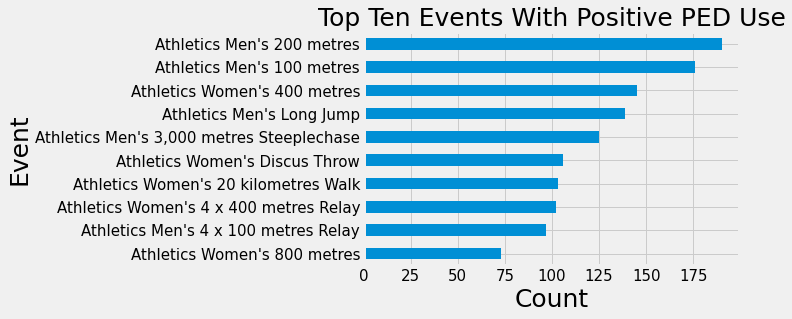

In [296]:
plt.style.use('fivethirtyeight')
plt.figure.figsize=(8,10)
top_ten.plot(kind='barh', fontsize=15, legend=False)
plt.title('Top Ten Events With Positive PED Use', fontsize=25)
plt.ylabel('Event', fontsize=25)
plt.xlabel('Count', fontsize=25)
plt.savefig('../reports/figures/top_ten_doping_events.png', dpi='figure', orientation='landscape', bbox_inches='tight',
           transparent=True)

#### Creating dataframe for the 2012 and 2016 Games 

In [297]:
df = (df[df['year']<2017])
df = (df[df['year']>2011])
df = df.drop_duplicates().reset_index(drop=True)
df.name = df.name.str.replace(r"\(.*\)","")
df.name = [x.lower() for x in df.name]


In [298]:
df.flagged.value_counts()

1.0    67
Name: flagged, dtype: int64

# 

#### Next, I am going to scrape the tables from Olympic.org that contain the different events, athletes per event, ranking, and result (time/distance). I am going to start with the 100m Dash

# 

Men's 100 Meter Dash 2016-Rio

In [299]:
url = 'https://www.olympic.org/rio-2016/athletics/100m-men'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all(class_='table4')  

In [300]:
mens_100m_16 = fn.olympic_scraper(contents)
mens_100m_16 = fn.content_cleaner(mens_100m_16)
mens_100m_16.columns = ['rank', 'name', 'result']
mens_100m_16.insert(3, "event_x", "Athletics Men's 100 metres")
mens_100m_16.name = [x.strip() for x in mens_100m_16.name]
mens_100m_16.name = [x.lower() for x in mens_100m_16.name]
mens_100m_16

,rank,name,result,event_x
0,1.,usain bolt,9.81,Athletics Men's 100 metres
1,2.,justin gatlin,9.89,Athletics Men's 100 metres
2,3.,andre de grasse,9.91,Athletics Men's 100 metres
3,4.,yohan blake,9.93,Athletics Men's 100 metres
4,5.,akani simbine,9.94,Athletics Men's 100 metres
5,6.,ben youssef meite,9.96,Athletics Men's 100 metres
6,7.,jimmy vicaut,10.04,Athletics Men's 100 metres
7,8.,trayvon bromell,10.06,Athletics Men's 100 metres


#### This only matched 3 of the 7 values in the result column. There are names in the athletes df that include first, middle, and last names. I am going to transform the names in the dataframe to only be first and last names. First, I will create a list to hold the first and last names, then replace the names in the dataframe with the names from the list.

In [301]:
names = []
for x in df.name:
    x = x.replace('-', ' ')
    split = x.split()
    x = split[0] + ' ' + split[-1]
    names.append(x)


df['name'] = [x for x in names]


In [302]:
names = []
for x in mens_100m_16.name:
    split = x.split()
    x = split[0] + ' ' + split[-1]
    x = x.replace('-', ' ')
    names.append(x)


mens_100m_16['name'] = [x for x in names]

In [303]:
def format_name(df):
    df.name = [x.strip() for x in df.name]
    names = []
    for x in df.name:
        split = x.split()
        x = split[0] + ' ' + split[-1]
        x = x.replace('-', ' ')
        names.append(x)
    df.name = [x for x in names]
    return df

In [304]:
df = pd.merge(df, mens_100m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100m_mens_rio'))
len(df.result.value_counts())

7

#### Function for scraping the event result at the 2012 London Summer Olympic Games

In [305]:
def olympic_query_london(event):
    url = 'https://www.olympic.org/london-2012/athletics/' + str(event)
    req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                             ca_certs=certifi.where())
    res = req.request('GET', url)
    soup = BeautifulSoup(res.data, 'html.parser')
    contents = soup.find_all(class_ = 'table4')
    return contents

#### Function for scraping the event result at the 2016 Rio Summer Olympic Games

In [306]:
def olympic_query(event):
    url = 'https://www.olympic.org/rio-2016/athletics/' + str(event)
    req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                             ca_certs=certifi.where())
    res = req.request('GET', url)
    soup = BeautifulSoup(res.data, 'html.parser')
    contents = soup.find_all(class_ = 'table4')
    return contents

#### Mens 100 Meter Dash 2012-London

In [307]:
mens_100m_12 = olympic_query_london('100m-men')
mens_100m_12 = fn.olympic_scraper(mens_100m_12)
mens_100m_12 = mens_100m_12.drop([31,86,87])
mens_100m_12 = content_cleaner(mens_100m_12)
mens_100m_12.columns = ['rank', 'name', 'result']
mens_100m_12.insert(3, "event_x", "Athletics Men's 100 metres")
mens_100m_12.name = [x.strip() for x in mens_100m_12.name]
mens_100m_12.name = [x.lower() for x in mens_100m_12.name]
mens_100m_12.name = mens_100m_12.name.replace('ben meite', 'ben mit')
mens_100m_12.name = mens_100m_12.name.replace('james dasaolu', 'oyeyemi dasaolu')
mens_100m_12.name = mens_100m_12.name.replace('suwaibou sanneh', 'su sanneh')
mens_100m_12.name = mens_100m_12.name.replace('bingtian su', 'su bingtian')
mens_100m_12.name = mens_100m_12.name.replace('rondel sorrillo', 'rondell sorillo')
mens_100m_12.name = mens_100m_12.name.replace('amr seoud', 'amru seoud')
mens_100m_12.name = mens_100m_12.name.replace('dariusz kuc', 'dariusz ku')
mens_100m_12.name = mens_100m_12.name.replace('nilson andre', 'nilson andr')
mens_100m_12.name = mens_100m_12.name.replace('miguel lopez', 'miguel lpez')
mens_100m_12.name = mens_100m_12.name.replace('angel rodriguez', 'ngel rodrguez')
mens_100m_12.name = mens_100m_12.name.replace('obinna metu', 'joseph metu')
mens_100m_12.name = mens_100m_12.name.replace('gerard kobeane', 'grard koban')
mens_100m_12.name = mens_100m_12.name.replace('berenger bosse', 'branger bosse')
mens_100m_12.name = mens_100m_12.name.replace('fabrice coiffic', 'louis coiffic')
mens_100m_12.name = mens_100m_12.name.replace("jmaal alexander", "j'maal alexander")
mens_100m_12.name = mens_100m_12.name.replace('massoud azizi', 'masoud azizi')
mens_100m_12

,rank,name,result,event_x
0,1.,usain bolt,9.63,Athletics Men's 100 metres
1,2.,yohan blake,9.75,Athletics Men's 100 metres
2,3.,justin gatlin,9.79,Athletics Men's 100 metres
3,4.,tyson gay,9.80,Athletics Men's 100 metres
4,5.,ryan bailey,9.88,Athletics Men's 100 metres
5,6.,churandy martina,9.94,Athletics Men's 100 metres
6,7.,richard thompson,9.98,Athletics Men's 100 metres
7,8.,asafa powell,11.99,Athletics Men's 100 metres
8,1.,justin gatlin,9.82,Athletics Men's 100 metres
9,2.,yohan blake,9.85,Athletics Men's 100 metres


In [308]:
df = pd.merge(df, mens_100m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100m_mens_london'))
len(df.result_100m_mens_london.value_counts())

78

#### Women's 100 meter dash 2016-rio

In [309]:
womens_100m_16 = olympic_query('100m-women')
womens_100m_16 = fn.olympic_scraper(womens_100m_16)
womens_100m_16 = content_cleaner(womens_100m_16)
womens_100m_16.columns = ['rank', 'name', 'result']
womens_100m_16.insert(3, "event_x", "Athletics Women's 100 metres")
womens_100m_16.name = [x.strip() for x in womens_100m_16.name]
womens_100m_16 = womens_100m_16.replace('marie josee ta lou', 'marie jose lou')

womens_100m_16

,rank,name,result,event_x
0,1.,elaine thompson,10.71,Athletics Women's 100 metres
1,2.,tori bowie,10.83,Athletics Women's 100 metres
2,3.,shelly pryce,10.86,Athletics Women's 100 metres
3,4.,marie lou,10.86,Athletics Women's 100 metres
4,5.,dafne schippers,10.90,Athletics Women's 100 metres
5,6.,michelle ahye,10.92,Athletics Women's 100 metres
6,7.,english gardner,10.94,Athletics Women's 100 metres
7,8.,christania williams,11.80,Athletics Women's 100 metres


In [310]:
df = pd.merge(df, womens_100m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100m_womens_rio'))
df.result_100m_womens_rio.value_counts()

10.86    3
10.92    2
10.71    1
11.80    1
10.90    1
10.94    1
Name: result_100m_womens_rio, dtype: int64

#### Womens 100 meter dash 2012-london

In [311]:
womens_100m_12 = olympic_query_london('100m-women')
womens_100m_12 = fn.olympic_scraper(womens_100m_12)
womens_100m_12 = womens_100m_12.drop(121)
womens_100m_12 = content_cleaner(womens_100m_12)
womens_100m_12.columns = ['rank', 'name', 'result']
womens_100m_12.insert(3, "event_x", "Athletics Women's 100 metres")
womens_100m_12.name = [x.strip() for x in womens_100m_12.name]
womens_100m_12 = womens_100m_12.replace('marie josee ta lou', 'marie jose lou')

womens_100m_12

,rank,name,result,event_x
0,1.,shelly pryce,10.75,Athletics Women's 100 metres
1,2.,carmelita jeter,10.78,Athletics Women's 100 metres
2,3.,veronica brown,10.81,Athletics Women's 100 metres
3,4.,tianna bartoletta,10.85,Athletics Women's 100 metres
4,5.,allyson felix,10.89,Athletics Women's 100 metres
5,6.,kelly baptiste,10.94,Athletics Women's 100 metres
6,7.,murielle ahoure,11.00,Athletics Women's 100 metres
7,8.,blessing okagbare,11.01,Athletics Women's 100 metres
8,1.,carmelita jeter,10.83,Athletics Women's 100 metres
9,2.,shelly pryce,10.85,Athletics Women's 100 metres


In [312]:
df = pd.merge(df, womens_100m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100m_womens_london'))
len(df.result_100m_womens_london.value_counts())

64

### Next, I will join the 200m dash results
mens 200 meter 2016-Rio

In [313]:
mens_200m_16 = olympic_query('200m-men')
mens_200m_16 = fn.olympic_scraper(mens_200m_16)
mens_200m_16 = content_cleaner(mens_200m_16)
mens_200m_16.columns = ['rank', 'name', 'result']
mens_200m_16.insert(3, "event_x", "Athletics Men's 200 metres")
mens_200m_16 = format_name(mens_200m_16)
mens_200m_16.name = mens_200m_16.name.replace('alonso edward', 'alonso henry')
mens_200m_16.name = mens_200m_16.name.replace('christophe lemaitre', 'christophe lematre')

mens_200m_16

,rank,name,result,event_x
0,1.,usain bolt,19.78,Athletics Men's 200 metres
1,2.,andre grasse,20.02,Athletics Men's 200 metres
2,3.,christophe lematre,20.12,Athletics Men's 200 metres
3,4.,adam gemili,20.12,Athletics Men's 200 metres
4,5.,churandy martina,20.13,Athletics Men's 200 metres
5,6.,lashawn merritt,20.19,Athletics Men's 200 metres
6,7.,alonso henry,20.23,Athletics Men's 200 metres
7,8.,ramil guliyev,20.43,Athletics Men's 200 metres


In [314]:
df = pd.merge(df, mens_200m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_200m_mens_rio'))

len(df['result_200m_mens_rio'].value_counts())

7

#### Men's 200 meter 2012-London

In [315]:
mens_200m_12 = olympic_query_london('200m-men')
mens_200m_12 = fn.olympic_scraper(mens_200m_12)
mens_200m_12 = mens_200m_12.drop([30,31,85,86])
mens_200m_12 = content_cleaner(mens_200m_12)
mens_200m_12.columns = ['rank', 'name', 'result']
mens_200m_12.insert(3, "event_x", "Athletics Men's 200 metres")
mens_200m_12 = format_name(mens_200m_12)
mens_200m_12.name = mens_200m_12.name.replace('alonso edward', 'alonso henry')
mens_200m_12.name = mens_200m_12.name.replace('christophe lemaitre', 'christophe lematre')

mens_200m_12

,rank,name,result,event_x
0,1.,usain bolt,19.32,Athletics Men's 200 metres
1,2.,yohan blake,19.44,Athletics Men's 200 metres
2,3.,warren weir,19.84,Athletics Men's 200 metres
3,4.,wallace spearmon,19.90,Athletics Men's 200 metres
4,5.,churandy martina,20.00,Athletics Men's 200 metres
5,6.,christophe lematre,20.19,Athletics Men's 200 metres
6,7.,alex quinonez,20.57,Athletics Men's 200 metres
7,8.,anaso jobodwana,20.69,Athletics Men's 200 metres
8,1.,yohan blake,20.01,Athletics Men's 200 metres
9,2.,wallace spearmon,20.02,Athletics Men's 200 metres


In [316]:
df = pd.merge(df, mens_200m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_200m_mens_london'))

len(df['result_200m_mens_london'].value_counts())

50

#### Women's 200 meter 2016-Rio

In [317]:
womens_200m_16 = olympic_query('200m-women')
womens_200m_16 = fn.olympic_scraper(womens_200m_16)
womens_200m_16 = content_cleaner(womens_200m_16)
womens_200m_16.columns = ['rank', 'name', 'result']
womens_200m_16.insert(3, "event_x", "Athletics Women's 200 metres")
womens_200m_16.name = [x.strip() for x in womens_200m_16.name]
womens_200m_16 = womens_200m_16.replace('marie lou', 'marie lou')
womens_200m_16 = womens_200m_16.replace('dina smith', 'geraldina smith')
womens_200m_16

,rank,name,result,event_x
0,1.,elaine thompson,21.78,Athletics Women's 200 metres
1,2.,dafne schippers,21.88,Athletics Women's 200 metres
2,3.,tori bowie,22.15,Athletics Women's 200 metres
3,4.,marie lou,22.21,Athletics Women's 200 metres
4,5.,geraldina smith,22.31,Athletics Women's 200 metres
5,6.,michelle ahye,22.34,Athletics Women's 200 metres
6,7.,deajah stevens,22.65,Athletics Women's 200 metres
7,8.,ivet collio,22.69,Athletics Women's 200 metres


In [318]:
df = pd.merge(df, womens_200m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_200m_womens_rio'))
len(df.result_200m_womens_rio.value_counts())

7

#### Women's 200 meter 2012-London

In [319]:
womens_200m_12 = olympic_query_london('200m-women')
womens_200m_12 = fn.olympic_scraper(womens_200m_12)
womens_200m_12 = womens_200m_12.drop([84,85])
womens_200m_12 = content_cleaner(womens_200m_12)
womens_200m_12.columns = ['rank', 'name', 'result']
womens_200m_12.insert(3, "event_x", "Athletics Women's 200 metres")
womens_200m_12.name = [x.strip() for x in womens_200m_12.name]
womens_200m_12 = womens_200m_12.replace('marie lou', 'marie lou')
womens_200m_12 = womens_200m_12.replace('dina smith', 'geraldina smith')
womens_200m_12

,rank,name,result,event_x
0,1.,allyson felix,21.88,Athletics Women's 200 metres
1,2.,shelly pryce,22.09,Athletics Women's 200 metres
2,3.,carmelita jeter,22.14,Athletics Women's 200 metres
3,4.,veronica brown,22.38,Athletics Women's 200 metres
4,5.,sanya ross,22.39,Athletics Women's 200 metres
5,6.,murielle ahoure,22.57,Athletics Women's 200 metres
6,7.,myriam soumare,22.63,Athletics Women's 200 metres
7,8.,semoy hackett,22.87,Athletics Women's 200 metres
8,1.,sanya ross,22.30,Athletics Women's 200 metres
9,2.,allyson felix,22.31,Athletics Women's 200 metres


In [320]:
df = pd.merge(df, womens_200m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_200m_womens_london'))
len(df.result_200m_womens_london.value_counts())

46

#### Mens 110 meter hurdles 2016-Rio

In [321]:
mens_110h_16 = olympic_query('110m-hurdles-men')
mens_110h_16 = fn.olympic_scraper(mens_110h_16)
mens_110h_16 = mens_110h_16.drop(7)
mens_110h_16 = content_cleaner(mens_110h_16)
mens_110h_16.columns = ['rank', 'name', 'result']
mens_110h_16.insert(3, "event_x", "Athletics Men's 110 metres Hurdles")
mens_110h_16 = format_name(mens_110h_16)
mens_110h_16.name = mens_110h_16.name.replace('orlando ortega', 'orlando alejo')

mens_110h_16

,rank,name,result,event_x
0,1.,omar mcleod,13.05,Athletics Men's 110 metres Hurdles
1,2.,orlando alejo,13.17,Athletics Men's 110 metres Hurdles
2,3.,dimitri bascou,13.24,Athletics Men's 110 metres Hurdles
3,4.,pascal lagarde,13.29,Athletics Men's 110 metres Hurdles
4,5.,devon allen,13.31,Athletics Men's 110 metres Hurdles
5,6.,johnathan cabral,13.40,Athletics Men's 110 metres Hurdles
6,7.,milan trajkovic,13.41,Athletics Men's 110 metres Hurdles


In [322]:
df = pd.merge(df, mens_110h_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_110h_mens_rio'))

df.result_110h_mens_rio.value_counts()

13.17    2
13.24    2
13.31    1
13.40    1
13.05    1
13.41    1
13.29    1
Name: result_110h_mens_rio, dtype: int64

#### Men's 110 meter hurdles 2012-London

In [323]:
mens_110h_12 = olympic_query_london('110m-hurdles-men')
mens_110h_12 = fn.olympic_scraper(mens_110h_12)
mens_110h_12 = mens_110h_12.drop([7,31,32,78,79,80,
                                 81,82,83,84,85,86])
mens_110h_12 = content_cleaner(mens_110h_12)
mens_110h_12.columns = ['rank', 'name', 'result']
mens_110h_12.insert(3, "event_x", "Athletics Men's 110 metres Hurdles")
mens_110h_12 = format_name(mens_110h_12)
mens_110h_12.name = mens_110h_12.name.replace('orlando ortega', 'orlando alejo')

mens_110h_12

,rank,name,result,event_x
0,1.,aries merritt,12.92,Athletics Men's 110 metres Hurdles
1,2.,jason richardson,13.04,Athletics Men's 110 metres Hurdles
2,3.,hansle parchment,13.12,Athletics Men's 110 metres Hurdles
3,4.,lawrence clarke,13.39,Athletics Men's 110 metres Hurdles
4,5.,ryan brathwaite,13.40,Athletics Men's 110 metres Hurdles
5,6.,orlando alejo,13.43,Athletics Men's 110 metres Hurdles
6,7.,lehann fourie,13.53,Athletics Men's 110 metres Hurdles
8,1.,aries merritt,12.94,Athletics Men's 110 metres Hurdles
9,2.,dayron robles,13.10,Athletics Men's 110 metres Hurdles
10,3.,jason richardson,13.13,Athletics Men's 110 metres Hurdles


In [324]:
df = pd.merge(df, mens_110h_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_110h_mens_london'))

df.result_110h_mens_london.value_counts()

13.26    5
13.55    3
13.42    3
13.52    3
13.47    2
13.59    2
14.82    2
13.67    2
14.21    2
13.74    2
13.87    2
13.23    2
13.43    2
13.57    2
13.49    2
13.32    1
13.14    1
13.53    1
12.92    1
13.07    1
13.41    1
13.33    1
13.54    1
13.77    1
13.90    1
13.12    1
13.45    1
12.94    1
13.51    1
13.04    1
13.62    1
13.48    1
13.40    1
13.28    1
13.63    1
13.35    1
13.46    1
13.13    1
14.00    1
13.65    1
Name: result_110h_mens_london, dtype: int64

#### Women's 100 meter hurdles 2016-Rio

In [325]:
womens_100h_16 = olympic_query('100m-hurdles-women')
womens_100h_16 = fn.olympic_scraper(womens_100h_16)
womens_100h_16 = content_cleaner(womens_100h_16)
womens_100h_16.columns = ['rank', 'name', 'result']
womens_100h_16.insert(3, "event_x", "Athletics Women's 100 metres Hurdles")
womens_100h_16 = format_name(womens_100h_16)


womens_100h_16

,rank,name,result,event_x
0,1.,brianna rollins,12.48,Athletics Women's 100 metres Hurdles
1,2.,nia ali,12.59,Athletics Women's 100 metres Hurdles
2,3.,kristi castlin,12.61,Athletics Women's 100 metres Hurdles
3,4.,cindy ofili,12.63,Athletics Women's 100 metres Hurdles
4,5.,cindy roleder,12.74,Athletics Women's 100 metres Hurdles
5,6.,pedrya seymour,12.76,Athletics Women's 100 metres Hurdles
6,7.,tiffany porter,12.76,Athletics Women's 100 metres Hurdles
7,8.,phylicia george,12.89,Athletics Women's 100 metres Hurdles


In [326]:
df = pd.merge(df, womens_100h_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100h_womens_rio'))
len(df.result_100h_womens_rio.value_counts())

7

#### Women's 110 meter hurdles 2012-London

In [327]:
womens_100h_12 = olympic_query_london('100m-hurdles-women')
womens_100h_12 = fn.olympic_scraper(womens_100h_12)
womens_100h_12 = womens_100h_12.drop([30,31,32,80,
                                     81,82,83])
womens_100h_12 = content_cleaner(womens_100h_12)
womens_100h_12.columns = ['rank', 'name', 'result']
womens_100h_12.insert(3, "event_x", "Athletics Women's 100 metres Hurdles")
womens_100h_12 = format_name(womens_100h_12)


womens_100h_12

,rank,name,result,event_x
0,1.,sally pearson,12.35,Athletics Women's 100 metres Hurdles
1,2.,dawn harper,12.37,Athletics Women's 100 metres Hurdles
2,3.,kellie wells,12.48,Athletics Women's 100 metres Hurdles
3,4.,lolo jones,12.58,Athletics Women's 100 metres Hurdles
4,5.,nevin yanit,12.58,Athletics Women's 100 metres Hurdles
5,6.,phylicia george,12.65,Athletics Women's 100 metres Hurdles
6,7.,jessica zelinka,12.69,Athletics Women's 100 metres Hurdles
7,8.,beate schrott,13.07,Athletics Women's 100 metres Hurdles
8,1.,sally pearson,12.39,Athletics Women's 100 metres Hurdles
9,2.,dawn harper,12.46,Athletics Women's 100 metres Hurdles


In [328]:
df = pd.merge(df, womens_100h_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_100h_womens_london'))
len(df.result_100h_womens_london.value_counts())

36

In [329]:
pd.pivot_table(df, index=['event_x'], values='flagged', aggfunc='count')

,flagged
event_x,
"Athletics Men's 1,500 metres",0
"Athletics Men's 10,000 metres",1
Athletics Men's 100 metres,8
Athletics Men's 110 metres Hurdles,3
Athletics Men's 20 kilometres Walk,4
Athletics Men's 200 metres,11
"Athletics Men's 3,000 metres Steeplechase",2
Athletics Men's 4 x 100 metres Relay,2
Athletics Men's 4 x 400 metres Relay,1


### 3000m Steeplechase
Men's 2016-Rio

In [330]:
mens_3000steep_16 = olympic_query('3000m-steeplechase-men')
mens_3000steep_16 = fn.olympic_scraper(mens_3000steep_16)
mens_3000steep_16 = mens_3000steep_16.drop([11,12,13,14])
mens_3000steep_16 = content_cleaner(mens_3000steep_16)
mens_3000steep_16.columns = ['rank', 'name', 'result']
mens_3000steep_16.insert(3, "event_x", "Athletics Men's 3,000 metres Steeplechase")
mens_3000steep_16 = format_name(mens_3000steep_16)
mens_3000steep_16 = mens_3000steep_16.replace('mahiedine mekhissi', 'mahiedine benabbad')
mens_3000steep_16 = mens_3000steep_16.replace('soufiane elbakkali', 'soufiane bakkali')

mens_3000steep_16

,rank,name,result,event_x
0,1.,conseslus kipruto,8:03.28,"Athletics Men's 3,000 metres Steeplechase"
1,2.,evan jager,8:04.28,"Athletics Men's 3,000 metres Steeplechase"
2,3.,mahiedine benabbad,8:11.52,"Athletics Men's 3,000 metres Steeplechase"
3,4.,soufiane bakkali,8:14.35,"Athletics Men's 3,000 metres Steeplechase"
4,5.,yoann kowal,8:16.75,"Athletics Men's 3,000 metres Steeplechase"
5,6.,brimin kipruto,8:18.79,"Athletics Men's 3,000 metres Steeplechase"
6,7.,hillary bor,8:22.74,"Athletics Men's 3,000 metres Steeplechase"
7,8.,donald cabral,8:25.81,"Athletics Men's 3,000 metres Steeplechase"
8,9.,altobeli silva,8:26.30,"Athletics Men's 3,000 metres Steeplechase"
9,10.,matthew hughes,8:36.83,"Athletics Men's 3,000 metres Steeplechase"


In [331]:
df = pd.merge(df, mens_3000steep_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_3000steep_mens_rio'))

len(df.result_3000steep_mens_rio.value_counts())

11

#### Men's 3000 meter steeplechase 2012-London

In [332]:
mens_3000steep_12 = olympic_query_london('3000m-steeplechase-men')
mens_3000steep_12 = fn.olympic_scraper(mens_3000steep_12)
mens_3000steep_12 = mens_3000steep_12.drop([13,14,52,53])
mens_3000steep_12 = content_cleaner(mens_3000steep_12)
mens_3000steep_12.columns = ['rank', 'name', 'result']
mens_3000steep_12.insert(3, "event_x", "Athletics Men's 3,000 metres Steeplechase")
mens_3000steep_12 = format_name(mens_3000steep_12)
mens_3000steep_12 = mens_3000steep_12.replace('mahiedine mekhissi', 'mahiedine benabbad')
mens_3000steep_12 = mens_3000steep_12.replace('soufiane elbakkali', 'soufiane bakkali')

mens_3000steep_12

,rank,name,result,event_x
0,1.,ezekiel kemboi,8:18.56,"Athletics Men's 3,000 metres Steeplechase"
1,2.,mahiedine benabbad,8:19.08,"Athletics Men's 3,000 metres Steeplechase"
2,3.,abel mutai,8:19.73,"Athletics Men's 3,000 metres Steeplechase"
3,4.,roba gary,8:20.00,"Athletics Men's 3,000 metres Steeplechase"
4,5.,brimin kipruto,8:23.03,"Athletics Men's 3,000 metres Steeplechase"
5,6.,evan jager,8:23.87,"Athletics Men's 3,000 metres Steeplechase"
6,7.,hamid ezzine,8:24.90,"Athletics Men's 3,000 metres Steeplechase"
7,8.,donald cabral,8:25.91,"Athletics Men's 3,000 metres Steeplechase"
8,9.,tarik akdag,8:27.64,"Athletics Men's 3,000 metres Steeplechase"
9,10.,ion luchianov,8:28.15,"Athletics Men's 3,000 metres Steeplechase"


In [333]:
df = pd.merge(df, mens_3000steep_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_3000steep_mens_london'))

len(df.result_3000steep_mens_london.value_counts())

32

#### Women's 3000 meter steeplechase 2016-Rio

In [334]:
womens_3000steep_16 = olympic_query('3000m-steeplechase-women')
womens_3000steep_16 = fn.olympic_scraper(womens_3000steep_16)
womens_3000steep_16 = womens_3000steep_16.drop([11,12,13,14])
womens_3000steep_16 = content_cleaner(womens_3000steep_16)
womens_3000steep_16.columns = ['rank', 'name', 'result']
womens_3000steep_16.insert(3, "event_x", "Athletics Women's 3,000 metres Steeplechase")
womens_3000steep_16 = format_name(womens_3000steep_16)

womens_3000steep_16

,rank,name,result,event_x
0,1.,ruth jebet,8:59.75,"Athletics Women's 3,000 metres Steeplechase"
1,2.,hyvin jepkemoi,9:07.12,"Athletics Women's 3,000 metres Steeplechase"
2,3.,emma coburn,9:07.63,"Athletics Women's 3,000 metres Steeplechase"
3,4.,beatrice chepkoech,9:16.05,"Athletics Women's 3,000 metres Steeplechase"
4,5.,sofia assefa,9:17.15,"Athletics Women's 3,000 metres Steeplechase"
5,6.,gesa krause,9:18.41,"Athletics Women's 3,000 metres Steeplechase"
6,7.,madeline hills,9:20.38,"Athletics Women's 3,000 metres Steeplechase"
7,8.,colleen quigley,9:21.10,"Athletics Women's 3,000 metres Steeplechase"
8,9.,genevieve lacaze,9:21.21,"Athletics Women's 3,000 metres Steeplechase"
9,10.,lalita babar,9:22.74,"Athletics Women's 3,000 metres Steeplechase"


In [335]:
df = pd.merge(df, womens_3000steep_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_3000steep_womens_rio'))
len(df.result_3000steep_womens_rio.value_counts())

11

#### Women's 3000 meter steeplechase 2012-London

In [336]:
womens_3000steep_12 = olympic_query_london('3000m-steeplechase-women')
womens_3000steep_12 = fn.olympic_scraper(womens_3000steep_12)
womens_3000steep_12 = womens_3000steep_12.drop([13,14, 57,58])
womens_3000steep_12 = content_cleaner(womens_3000steep_12)
womens_3000steep_12.columns = ['rank', 'name', 'result']
womens_3000steep_12.insert(3, "event_x", "Athletics Women's 3,000 metres Steeplechase")
womens_3000steep_12 = format_name(womens_3000steep_12)

womens_3000steep_12

,rank,name,result,event_x
0,1.,habiba ghribi,9:08.37,"Athletics Women's 3,000 metres Steeplechase"
1,2.,sofia assefa,9:09.84,"Athletics Women's 3,000 metres Steeplechase"
2,3.,milcah cheywa,9:09.88,"Athletics Women's 3,000 metres Steeplechase"
3,4.,hiwot ayalew,9:12.98,"Athletics Women's 3,000 metres Steeplechase"
4,5.,etenesh diro,9:19.89,"Athletics Women's 3,000 metres Steeplechase"
5,6.,antje schmidt,9:21.78,"Athletics Women's 3,000 metres Steeplechase"
6,7.,gesa krause,9:23.52,"Athletics Women's 3,000 metres Steeplechase"
7,8.,emma coburn,9:23.54,"Athletics Women's 3,000 metres Steeplechase"
8,9.,mercy njoroge,9:26.73,"Athletics Women's 3,000 metres Steeplechase"
9,10.,clarisse cruz,9:32.44,"Athletics Women's 3,000 metres Steeplechase"


In [337]:
df = pd.merge(df, womens_3000steep_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_3000steep_womens_london'))
len(df.result_3000steep_womens_london.value_counts())

32

### Marathon
Men's 2016-Rio

In [338]:
mens_marathon_16 = olympic_query('marathon-men')
mens_marathon_16 = fn.olympic_scraper(mens_marathon_16)
mens_marathon_16 = mens_marathon_16.drop([140,141,142,143,144,145,146,147,148,149,150,151,152,153,154])
mens_marathon_16 = content_cleaner(mens_marathon_16)
mens_marathon_16.columns = ['rank', 'name', 'result']
mens_marathon_16.insert(3, "event_x", "Athletics Men's Marathon")
mens_marathon_16 = format_name(mens_marathon_16)

mens_marathon_16

,rank,name,result,event_x
0,1.,eliud rotich,2:08:44,Athletics Men's Marathon
1,2.,feyisa lilesa,2:09:54,Athletics Men's Marathon
2,3.,galen rupp,2:10:05,Athletics Men's Marathon
3,4.,ghirmay ghebreslassie,2:11:04,Athletics Men's Marathon
4,5.,alphonce simbu,2:11:15,Athletics Men's Marathon
5,6.,jared ward,2:11:30,Athletics Men's Marathon
6,7.,tadesse abraham,2:11:42,Athletics Men's Marathon
7,8.,munyo mutai,2:11:49,Athletics Men's Marathon
8,9.,callum hawkins,2:11:52,Athletics Men's Marathon
9,10.,eric gillis,2:12:29,Athletics Men's Marathon


In [339]:
df = pd.merge(df, mens_marathon_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_marathon_mens_rio'))
len(df.result_marathon_mens_rio.value_counts())

77

Men's marathon 2012-London

In [340]:
mens_marathon_12 = olympic_query_london('marathon-men')
mens_marathon_12 = fn.olympic_scraper(mens_marathon_12)
mens_marathon_12 = mens_marathon_12.drop(range(85,105))
mens_marathon_12 = content_cleaner(mens_marathon_12)
mens_marathon_12.columns = ['rank', 'name', 'result']
mens_marathon_12.insert(3, "event_x", "Athletics Men's Marathon")
mens_marathon_12 = format_name(mens_marathon_12)

mens_marathon_12

,rank,name,result,event_x
0,1.,stephen kiprotich,2:08:01,Athletics Men's Marathon
1,2.,abel kirui,2:08:27,Athletics Men's Marathon
2,3.,wilson kiprotich,2:09:37,Athletics Men's Marathon
3,4.,mebrahtom keflezighi,2:11:06,Athletics Men's Marathon
4,5.,marilson santos,2:11:10,Athletics Men's Marathon
5,6.,kentaro nakamoto,2:11:16,Athletics Men's Marathon
6,7.,cuthbert nyasango,2:12:08,Athletics Men's Marathon
7,8.,paulo paula,2:12:17,Athletics Men's Marathon
8,9.,henryk szost,2:12:28,Athletics Men's Marathon
9,10.,ruggero pertile,2:12:45,Athletics Men's Marathon


In [341]:
df = pd.merge(df, mens_marathon_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_marathon_mens_london'))
len(df.result_marathon_mens_london.value_counts())

46

#### Women's marathon 2016-Rio

In [342]:
womens_marathon_16 = olympic_query('marathon-women')
womens_marathon_16 = fn.olympic_scraper(womens_marathon_16)
womens_marathon_16 = womens_marathon_16.drop([133,134,135,136,137,138,139,140,141,142,143,
                                              144,145,146,147,148,149,150,151,152,153,154,
                                              155,156])
womens_marathon_16 = content_cleaner(womens_marathon_16)
womens_marathon_16.columns = ['rank', 'name', 'result']
womens_marathon_16.insert(3, "event_x", "Athletics Women's Marathon")
womens_marathon_16 = format_name(womens_marathon_16)


womens_marathon_16

,rank,name,result,event_x
0,1.,jemima sumgong,2:24:04,Athletics Women's Marathon
1,2.,eunice kirwa,2:24:13,Athletics Women's Marathon
2,3.,mare dibaba,2:24:30,Athletics Women's Marathon
3,4.,tirfi tsegaye,2:24:47,Athletics Women's Marathon
4,5.,volha mazuronak,2:24:48,Athletics Women's Marathon
5,6.,shalane flanagan,2:25:26,Athletics Women's Marathon
6,7.,desiree linden,2:26:08,Athletics Women's Marathon
7,8.,rose chelimo,2:27:36,Athletics Women's Marathon
8,9.,amy cragg,2:28:25,Athletics Women's Marathon
9,10.,hye kim,2:28:36,Athletics Women's Marathon


In [343]:
df = pd.merge(df, womens_marathon_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_marathon_womens_rio'))
len(df.result_marathon_womens_rio.value_counts())

72

Women's marathon 2012-London

In [344]:
womens_marathon_12 = olympic_query_london('marathon-women')
womens_marathon_12 = fn.olympic_scraper(womens_marathon_12)
womens_marathon_12 = womens_marathon_12.drop(range(107,120))
womens_marathon_12 = content_cleaner(womens_marathon_12)
womens_marathon_12.columns = ['rank', 'name', 'result']
womens_marathon_12.insert(3, "event_x", "Athletics Women's Marathon")
womens_marathon_12 = format_name(womens_marathon_12)


womens_marathon_12

,rank,name,result,event_x
0,1.,tiki gelana,2:23:07,Athletics Women's Marathon
1,2.,priscah jeptoo,2:23:12,Athletics Women's Marathon
2,3.,tatyana arkhipova,2:23:29,Athletics Women's Marathon
3,4.,mary keitany,2:23:56,Athletics Women's Marathon
4,5.,xiaolin zhu,2:24:48,Athletics Women's Marathon
5,6.,jessica augusto,2:25:11,Athletics Women's Marathon
6,7.,valeria straneo,2:25:27,Athletics Women's Marathon
7,8.,albina ivanova,2:25:38,Athletics Women's Marathon
8,10.,shalane flanagan,2:25:51,Athletics Women's Marathon
9,11.,kara goucher,2:26:07,Athletics Women's Marathon


In [345]:
df = pd.merge(df, womens_marathon_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_marathon_womens_london'))
len(df.result_marathon_womens_london.value_counts())

47

### 20km Walk
Men's 2016-Rio

In [346]:
mens_20km_16 = olympic_query('20km-walk-men')
mens_20km_16 = fn.olympic_scraper(mens_20km_16)
mens_20km_16 = mens_20km_16.drop([63,64,65,66,67,68,69,70,71,72,73])
mens_20km_16 = content_cleaner(mens_20km_16)
mens_20km_16.columns = ['rank', 'name', 'result']
mens_20km_16.insert(3, "event_x", "Athletics Men's 20 kilometres Walk")
mens_20km_16 = format_name(mens_20km_16)
# mens_marathon_16 = mens_marathon_16.replace('Mahiedine Mekhissi', 'Mahiedine Mekhissi-Benabbad')
# mens_marathon_16 = mens_marathon_16.replace('Soufiane Elbakkali', 'Soufiane El-Bakkali')

mens_20km_16

,rank,name,result,event_x
0,1.,zhen wang,1:19:14,Athletics Men's 20 kilometres Walk
1,2.,zelin cai,1:19:26,Athletics Men's 20 kilometres Walk
2,3.,dane smith,1:19:37,Athletics Men's 20 kilometres Walk
3,4.,caio bonfim,1:19:42,Athletics Men's 20 kilometres Walk
4,5.,christopher linke,1:20:00,Athletics Men's 20 kilometres Walk
5,6.,tom bosworth,1:20:13,Athletics Men's 20 kilometres Walk
6,7.,daisuke matsunaga,1:20:22,Athletics Men's 20 kilometres Walk
7,8.,matteo giupponi,1:20:27,Athletics Men's 20 kilometres Walk
8,9.,manuel soto,1:20:36,Athletics Men's 20 kilometres Walk
9,10.,evan dunfee,1:20:49,Athletics Men's 20 kilometres Walk


In [347]:
df = pd.merge(df, mens_20km_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_20km_mens_rio'))
len(df.result_20km_mens_rio.value_counts())

22

#### Men's 20 km walk 2012-London

In [348]:
mens_20km_12 = olympic_query_london('20km-walk-men')
mens_20km_12 = fn.olympic_scraper(mens_20km_12)
mens_20km_12 = mens_20km_12.drop(range(48,54))
mens_20km_12 = content_cleaner(mens_20km_12)
mens_20km_12.columns = ['rank', 'name', 'result']
mens_20km_12.insert(3, "event_x", "Athletics Men's 20 kilometres Walk")
mens_20km_12 = format_name(mens_20km_12)
# mens_marathon_16 = mens_marathon_16.replace('Mahiedine Mekhissi', 'Mahiedine Mekhissi-Benabbad')
# mens_marathon_16 = mens_marathon_16.replace('Soufiane Elbakkali', 'Soufiane El-Bakkali')

mens_20km_12

,rank,name,result,event_x
0,1.,ding chen,1:18:46,Athletics Men's 20 kilometres Walk
1,2.,erick barrondo,1:18:57,Athletics Men's 20 kilometres Walk
2,3.,zhen wang,1:19:25,Athletics Men's 20 kilometres Walk
3,4.,zelin cai,1:19:44,Athletics Men's 20 kilometres Walk
4,5.,miguel lopez,1:19:49,Athletics Men's 20 kilometres Walk
5,6.,eder sanchez,1:19:52,Athletics Men's 20 kilometres Walk
6,7.,jared tallent,1:20:02,Athletics Men's 20 kilometres Walk
7,8.,bertrand moulinet,1:20:12,Athletics Men's 20 kilometres Walk
8,9.,robert heffernan,1:20:18,Athletics Men's 20 kilometres Walk
9,10.,irfan thodi,1:20:21,Athletics Men's 20 kilometres Walk


In [349]:
df = pd.merge(df, mens_20km_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_20km_mens_london'))
len(df.result_20km_mens_london.value_counts())

21

#### Women's 20 km walk 2016-Rio

In [350]:
womens_20km_16 = olympic_query('20km-race-walk-women')
womens_20km_16 = fn.olympic_scraper(womens_20km_16)
womens_20km_16 = womens_20km_16.drop([63,64,65,66,67,68,69,70,71,72,73])
womens_20km_16 = content_cleaner(womens_20km_16)
womens_20km_16.columns = ['rank', 'name', 'result']
womens_20km_16.insert(3, "event_x", "Athletics Women's 20 kilometres Walk")
womens_20km_16 = format_name(womens_20km_16)


womens_20km_16

,rank,name,result,event_x
0,1.,hong liu,1:28:35,Athletics Women's 20 kilometres Walk
1,2.,maria gonzalez,1:28:37,Athletics Women's 20 kilometres Walk
2,3.,xiuzhi lu,1:28:42,Athletics Women's 20 kilometres Walk
3,4.,antonella palmisano,1:29:03,Athletics Women's 20 kilometres Walk
4,5.,shijie qieyang,1:29:04,Athletics Women's 20 kilometres Walk
5,6.,ana cabecinha,1:29:23,Athletics Women's 20 kilometres Walk
6,7.,erica sena,1:29:29,Athletics Women's 20 kilometres Walk
7,8.,beatriz pascual,1:30:24,Athletics Women's 20 kilometres Walk
8,9.,regan lamble,1:30:28,Athletics Women's 20 kilometres Walk
9,10.,anezka drahotova,1:30:43,Athletics Women's 20 kilometres Walk


In [351]:
df = pd.merge(df, womens_20km_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_20km_womens_rio'))
len(df.result_20km_womens_rio.value_counts())

22

#### Women's 20 km walk 2012-London

In [352]:
womens_20km_12 = olympic_query_london('20km-race-walk-women')
womens_20km_12 = fn.olympic_scraper(womens_20km_12)
womens_20km_12 = womens_20km_12.drop(range(54,60))
womens_20km_12 = content_cleaner(womens_20km_12)
womens_20km_12.columns = ['rank', 'name', 'result']
womens_20km_12.insert(3, "event_x", "Athletics Women's 20 kilometres Walk")
womens_20km_12 = format_name(womens_20km_12)


womens_20km_12

,rank,name,result,event_x
0,1.,elena lashmanova,1:25:02,Athletics Women's 20 kilometres Walk
1,2.,shenjie qieyang,1:25:16,Athletics Women's 20 kilometres Walk
2,3.,hong liu,1:26:00,Athletics Women's 20 kilometres Walk
3,4.,anisya kirdyapkina,1:26:26,Athletics Women's 20 kilometres Walk
4,5.,xiuzhi lu,1:27:10,Athletics Women's 20 kilometres Walk
5,6.,elisa rigaudo,1:27:36,Athletics Women's 20 kilometres Walk
6,7.,beatriz pascual,1:27:56,Athletics Women's 20 kilometres Walk
7,8.,ana cabecinha,1:28:03,Athletics Women's 20 kilometres Walk
8,9.,maria vasco,1:28:14,Athletics Women's 20 kilometres Walk
9,10.,masumi fuchise,1:28:41,Athletics Women's 20 kilometres Walk


In [353]:
df = pd.merge(df, womens_20km_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_20km_womens_london'))
len(df.result_20km_womens_london.value_counts())

22

### 400m
Men's 400 meter 2016-Rio

In [354]:
mens_400m_16 = olympic_query('400m-men')
mens_400m_16 = fn.olympic_scraper(mens_400m_16)
mens_400m_16 = content_cleaner(mens_400m_16)
mens_400m_16.columns = ['rank', 'name', 'result']
mens_400m_16.insert(3, "event_x", "Athletics Men's 400 metres")
mens_400m_16 = format_name(mens_400m_16)

mens_400m_16

,rank,name,result,event_x
0,1.,wayde niekerk,43.03,Athletics Men's 400 metres
1,2.,kirani james,43.76,Athletics Men's 400 metres
2,3.,lashawn merritt,43.85,Athletics Men's 400 metres
3,4.,machel cedenio,44.01,Athletics Men's 400 metres
4,5.,karabo sibanda,44.25,Athletics Men's 400 metres
5,6.,ali khamis,44.36,Athletics Men's 400 metres
6,7.,bralon taplin,44.45,Athletics Men's 400 metres
7,8.,matthew smith,44.61,Athletics Men's 400 metres


In [355]:
df = pd.merge(df, mens_400m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_400m_mens_rio'))
len(df.result_400m_mens_rio.value_counts())

8

#### Men's 400 meter 2012-London

In [356]:
mens_400m_12 = olympic_query_london('400m-men')
mens_400m_12 = fn.olympic_scraper(mens_400m_12)
mens_400m_12 = mens_400m_12.drop(range(78,82))
mens_400m_12 = content_cleaner(mens_400m_12)
mens_400m_12.columns = ['rank', 'name', 'result']
mens_400m_12.insert(3, "event_x", "Athletics Men's 400 metres")
mens_400m_12 = format_name(mens_400m_12)

mens_400m_12

,rank,name,result,event_x
0,1.,kirani james,43.94,Athletics Men's 400 metres
1,2.,luguelin santos,44.46,Athletics Men's 400 metres
2,3.,lalonde gordon,44.52,Athletics Men's 400 metres
3,4.,chris brown,44.79,Athletics Men's 400 metres
4,5.,kevin borlee,44.81,Athletics Men's 400 metres
5,6.,jonathan borlee,44.83,Athletics Men's 400 metres
6,7.,demetrius pinder,44.98,Athletics Men's 400 metres
7,8.,steven solomon,45.14,Athletics Men's 400 metres
8,1.,lalonde gordon,44.58,Athletics Men's 400 metres
9,2.,kirani james,44.59,Athletics Men's 400 metres


In [357]:
df = pd.merge(df, mens_400m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_400m_mens_london'))
len(df.result_400m_mens_london.value_counts())

52

#### Women's 400 meter 2016-Rio

In [358]:
womens_400m_16 = olympic_query('400m-women')
womens_400m_16 = fn.olympic_scraper(womens_400m_16)
womens_400m_16 = content_cleaner(womens_400m_16)
womens_400m_16.columns = ['rank', 'name', 'result']
womens_400m_16.insert(3, "event_x", "Athletics Women's 400 metres")
womens_400m_16 = format_name(womens_400m_16)

womens_400m_16

,rank,name,result,event_x
0,1.,shaunae miller,49.44,Athletics Women's 400 metres
1,2.,allyson felix,49.51,Athletics Women's 400 metres
2,3.,shericka jackson,49.85,Athletics Women's 400 metres
3,4.,natasha hastings,50.34,Athletics Women's 400 metres
4,5.,phyllis francis,50.41,Athletics Women's 400 metres
5,6.,stephenie mcpherson,50.97,Athletics Women's 400 metres
6,7.,olha zemlyak,51.24,Athletics Women's 400 metres
7,8.,libania martinez,51.25,Athletics Women's 400 metres


In [359]:
df = pd.merge(df, womens_400m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_400m_womens_rio'))
len(df.result_400m_womens_rio.value_counts())

6

#### Women's 400 meter 2012-London

In [360]:
womens_400m_12 = olympic_query_london('400m-women')
womens_400m_12 = fn.olympic_scraper(womens_400m_12)
womens_400m_12 = womens_400m_12.drop(range(75,80))
womens_400m_12 = content_cleaner(womens_400m_12)
womens_400m_12.columns = ['rank', 'name', 'result']
womens_400m_12.insert(3, "event_x", "Athletics Women's 400 metres")
womens_400m_12 = format_name(womens_400m_12)

womens_400m_12

,rank,name,result,event_x
0,1.,sanya ross,49.55,Athletics Women's 400 metres
1,2.,christine ohuruogu,49.70,Athletics Women's 400 metres
2,3.,deedee trotter,49.72,Athletics Women's 400 metres
3,4.,amantle montsho,49.75,Athletics Women's 400 metres
4,5.,novlene mills,50.11,Athletics Women's 400 metres
5,6.,francena mccorory,50.33,Athletics Women's 400 metres
6,7.,rosemarie whyte,50.79,Athletics Women's 400 metres
7,,antonina krivoshapka,DPG / 50.17,Athletics Women's 400 metres
8,1.,deedee trotter,49.87,Athletics Women's 400 metres
9,2.,novlene mills,49.91,Athletics Women's 400 metres


In [361]:
df = pd.merge(df, womens_400m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_400m_womens_london'))
len(df.result_400m_womens_london.value_counts())

56

### 5000m
Men's 2016-Rio

In [362]:
mens_5000m_16 = olympic_query('5000m-men')
mens_5000m_16 = fn.olympic_scraper(mens_5000m_16)
mens_5000m_16 = mens_5000m_16.drop([15, 66])
mens_5000m_16 = content_cleaner(mens_5000m_16)
mens_5000m_16.columns = ['rank', 'name', 'result']
mens_5000m_16.insert(3, "event_x", "Athletics Men's 5,000 metres")
mens_5000m_16 = format_name(mens_5000m_16)

mens_5000m_16

,rank,name,result,event_x
0,1.,mohamed farah,13:03.30,"Athletics Men's 5,000 metres"
1,2.,paul chelimo,13:03.90,"Athletics Men's 5,000 metres"
2,3.,hagos gebrhiwet,13:04.35,"Athletics Men's 5,000 metres"
3,4.,mohammed ahmed,13:05.94,"Athletics Men's 5,000 metres"
4,5.,bernard lagat,13:06.78,"Athletics Men's 5,000 metres"
5,6.,andrew butchart,13:08.61,"Athletics Men's 5,000 metres"
6,7.,albert rop,13:08.79,"Athletics Men's 5,000 metres"
7,8.,joshua cheptegei,13:09.17,"Athletics Men's 5,000 metres"
8,9.,birhanu balew,13:09.26,"Athletics Men's 5,000 metres"
9,10.,abrar adem,13:09.56,"Athletics Men's 5,000 metres"


In [363]:
df = pd.merge(df, mens_5000m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_5000m_mens_rio'))
len(df.result_5000m_mens_rio.value_counts())

54

#### Men's 5000 meter 2012-London

In [364]:
mens_5000m_12 = olympic_query_london('5000m-men')
mens_5000m_12 = fn.olympic_scraper(mens_5000m_12)
mens_5000m_12 = mens_5000m_12.drop(56)
mens_5000m_12 = content_cleaner(mens_5000m_12)
mens_5000m_12.columns = ['rank', 'name', 'result']
mens_5000m_12.insert(3, "event_x", "Athletics Men's 5,000 metres")
mens_5000m_12 = format_name(mens_5000m_12)

mens_5000m_12

,rank,name,result,event_x
0,1.,mohamed farah,13:41.66,"Athletics Men's 5,000 metres"
1,2.,dejen gebremeskel,13:41.98,"Athletics Men's 5,000 metres"
2,3.,thomas longosiwa,13:42.36,"Athletics Men's 5,000 metres"
3,4.,bernard lagat,13:42.99,"Athletics Men's 5,000 metres"
4,5.,isiah koech,13:43.83,"Athletics Men's 5,000 metres"
5,6.,abdalaati iguider,13:44.19,"Athletics Men's 5,000 metres"
6,7.,galen rupp,13:45.04,"Athletics Men's 5,000 metres"
7,8.,juan barrios,13:45.30,"Athletics Men's 5,000 metres"
8,9.,hayle ibrahimov,13:45.37,"Athletics Men's 5,000 metres"
9,10.,lopez lomong,13:48.19,"Athletics Men's 5,000 metres"


In [365]:
df = pd.merge(df, mens_5000m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_5000m_mens_london'))
len(df.result_5000m_mens_london.value_counts())

39

#### Women's 5000 meter 2016-Rio

In [366]:
womens_5000m_16 = olympic_query('5000m-women')
womens_5000m_16 = fn.olympic_scraper(womens_5000m_16)
womens_5000m_16 = womens_5000m_16.drop(17)
womens_5000m_16 = content_cleaner(womens_5000m_16)
womens_5000m_16.columns = ['rank', 'name', 'result']
womens_5000m_16.insert(3, "event_x", "Athletics Women's 5,000 metres")
womens_5000m_16 = format_name(womens_5000m_16)

womens_5000m_16

,rank,name,result,event_x
0,1.,vivian cheruiyot,14:26.17,"Athletics Women's 5,000 metres"
1,2.,hellen obiri,14:29.77,"Athletics Women's 5,000 metres"
2,3.,almaz ayana,14:33.59,"Athletics Women's 5,000 metres"
3,4.,mercy cherono,14:42.89,"Athletics Women's 5,000 metres"
4,5.,senbere teferi,14:43.75,"Athletics Women's 5,000 metres"
5,6.,yasemin can,14:56.96,"Athletics Women's 5,000 metres"
6,7.,karoline grovdal,14:57.53,"Athletics Women's 5,000 metres"
7,8.,susan kuijken,15:00.69,"Athletics Women's 5,000 metres"
8,9.,eloise wellings,15:01.59,"Athletics Women's 5,000 metres"
9,10.,madeline hills,15:04.05,"Athletics Women's 5,000 metres"


In [367]:
df = pd.merge(df, womens_5000m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_5000m_womens_rio'))
df.result_5000m_womens_rio.value_counts()

14:26.17    2
15:01.59    2
15:10.35    1
15:34.97    1
16:14.24    1
15:04.05    1
15:08.89    1
15:56.11    1
14:43.75    1
14:29.77    1
14:56.96    1
15:12.09    1
15:00.69    1
Name: result_5000m_womens_rio, dtype: int64

#### Women's 5000 meter 2012-London

In [368]:
womens_5000m_12 = olympic_query_london('5000m-women')
womens_5000m_12 = fn.olympic_scraper(womens_5000m_12)
womens_5000m_12 = womens_5000m_12.drop([49,50])
womens_5000m_12 = content_cleaner(womens_5000m_12)
womens_5000m_12.columns = ['rank', 'name', 'result']
womens_5000m_12.insert(3, "event_x", "Athletics Women's 5,000 metres")
womens_5000m_12 = format_name(womens_5000m_12)

womens_5000m_12

,rank,name,result,event_x
0,1.,meseret defar,15:04.25,"Athletics Women's 5,000 metres"
1,2.,vivian cheruiyot,15:04.73,"Athletics Women's 5,000 metres"
2,3.,tirunesh dibaba,15:05.15,"Athletics Women's 5,000 metres"
3,4.,sally kipyego,15:05.79,"Athletics Women's 5,000 metres"
4,5.,gelete burka,15:10.66,"Athletics Women's 5,000 metres"
5,6.,viola kibiwot,15:11.59,"Athletics Women's 5,000 metres"
6,7.,joanne pavey,15:12.72,"Athletics Women's 5,000 metres"
7,8.,julia bleasdale,15:14.55,"Athletics Women's 5,000 metres"
8,9.,olga golovkina,15:17.88,"Athletics Women's 5,000 metres"
9,10.,shitaye eshete,15:19.13,"Athletics Women's 5,000 metres"


In [369]:
df = pd.merge(df, womens_5000m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_5000m_womens_london'))
df.result_5000m_womens_london.value_counts()

15:04.73    2
15:01.54    2
15:35.53    2
15:24.70    1
15:21.38    1
15:10.24    1
15:10.20    1
15:28.32    1
15:35.69    1
15:20.29    1
14:59.31    1
15:12.72    1
15:12.81    1
15:05.79    1
15:06.81    1
15:02.00    1
15:14.55    1
15:05.26    1
15:09.31    1
15:16.77    1
15:27.41    1
15:17.88    1
15:02.80    1
15:11.59    1
15:05.38    1
15:06.38    1
15:01.87    1
15:02.84    1
15:02.26    1
15:28.22    1
Name: result_5000m_womens_london, dtype: int64

### 800m
Men's 2016-Rio

In [370]:
mens_800m_16 = olympic_query('800m-men')
mens_800m_16 = fn.olympic_scraper(mens_800m_16)
mens_800m_16 = content_cleaner(mens_800m_16)
mens_800m_16.columns = ['rank', 'name', 'result']
mens_800m_16.insert(3, "event_x", "Athletics Men's 800 metres")
mens_800m_16 = format_name(mens_800m_16)

mens_800m_16

,rank,name,result,event_x
0,1.,david rudisha,1:42.15,Athletics Men's 800 metres
1,2.,taoufik makhloufi,1:42.61,Athletics Men's 800 metres
2,3.,clayton murphy,1:42.93,Athletics Men's 800 metres
3,4.,pierre bosse,1:43.41,Athletics Men's 800 metres
4,5.,ferguson rotich,1:43.55,Athletics Men's 800 metres
5,6.,marcin lewandowski,1:44.20,Athletics Men's 800 metres
6,7.,alfred kipketer,1:46.02,Athletics Men's 800 metres
7,8.,boris berian,1:46.15,Athletics Men's 800 metres


In [371]:
df = pd.merge(df, mens_800m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_800m_mens_rio'))
len(df.result_800m_mens_rio.value_counts())

8

#### Men's 800 meter 2012-London

In [372]:
mens_800m_12 = olympic_query_london('800m-men')
mens_800m_12 = fn.olympic_scraper(mens_800m_12)
mens_800m_12 = mens_800m_12.drop([32,84,85,86,87])
mens_800m_12 = content_cleaner(mens_800m_12)
mens_800m_12.columns = ['rank', 'name', 'result']
mens_800m_12.insert(3, "event_x", "Athletics Men's 800 metres")
mens_800m_12 = format_name(mens_800m_12)

mens_800m_12

,rank,name,result,event_x
0,1.,david rudisha,1:40.91,Athletics Men's 800 metres
1,2.,nijel amos,1:41.73,Athletics Men's 800 metres
2,3.,timothy kitum,1:42.53,Athletics Men's 800 metres
3,4.,duane solomon,1:42.82,Athletics Men's 800 metres
4,5.,nick symmonds,1:42.95,Athletics Men's 800 metres
5,6.,mohammed geleto,1:43.20,Athletics Men's 800 metres
6,7.,abubaker kaki,1:43.32,Athletics Men's 800 metres
7,8.,andrew osagie,1:43.77,Athletics Men's 800 metres
8,1.,mohammed geleto,1:44.34,Athletics Men's 800 metres
9,2.,david rudisha,1:44.35,Athletics Men's 800 metres


In [373]:
df = pd.merge(df, mens_800m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_800m_mens_london'))
len(df.result_800m_mens_london.value_counts())

45

#### Women's 800 meter 2016-Rio

In [374]:
womens_800m_16 = olympic_query('800m-women')
womens_800m_16 = fn.olympic_scraper(womens_800m_16)
womens_800m_16 = womens_800m_16.drop(23)
womens_800m_16 = content_cleaner(womens_800m_16)
womens_800m_16.columns = ['rank', 'name', 'result']
womens_800m_16.insert(3, "event_x", "Athletics Women's 800 metres")
womens_800m_16 = format_name(womens_800m_16)

womens_800m_16

,rank,name,result,event_x
0,1.,caster semenya,1:55.28,Athletics Women's 800 metres
1,2.,francine niyonsaba,1:56.49,Athletics Women's 800 metres
2,3.,margaret wambui,1:56.89,Athletics Women's 800 metres
3,4.,melissa bishop,1:57.02,Athletics Women's 800 metres
4,5.,joanna jozwik,1:57.37,Athletics Women's 800 metres
5,6.,lynsey sharp,1:57.69,Athletics Women's 800 metres
6,7.,marina arzamasova,1:59.10,Athletics Women's 800 metres
7,8.,kate grace,1:59.57,Athletics Women's 800 metres
8,1.,margaret wambui,1:59.21,Athletics Women's 800 metres
9,2.,francine niyonsaba,1:59.59,Athletics Women's 800 metres


In [375]:
df = pd.merge(df, womens_800m_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_800m_womens_rio'))
len(df.result_800m_womens_rio.value_counts())

18

#### Women's 800 meter 2012-London

In [376]:
womens_800m_12 = olympic_query_london('800m-women')
womens_800m_12 = fn.olympic_scraper(womens_800m_12)
womens_800m_12 = womens_800m_12.drop(range(72,77))
womens_800m_12 = content_cleaner(womens_800m_12)
womens_800m_12.columns = ['rank', 'name', 'result']
womens_800m_12.insert(3, "event_x", "Athletics Women's 800 metres")
womens_800m_12 = format_name(womens_800m_12)

womens_800m_12

,rank,name,result,event_x
0,1.,caster semenya,1:57.23,Athletics Women's 800 metres
1,2.,ekaterina poistogova,1:57.53,Athletics Women's 800 metres
2,3.,pamela jelimo,1:57.59,Athletics Women's 800 metres
3,4.,alysia montano,1:57.93,Athletics Women's 800 metres
4,5.,francine niyonsaba,1:59.63,Athletics Women's 800 metres
5,6.,janeth busienei,2:00.19,Athletics Women's 800 metres
6,,mariya savinova,DPG / 1:56.19,Athletics Women's 800 metres
7,,elena arzhakova,DPG / 1:59.21,Athletics Women's 800 metres
8,1.,caster semenya,1:57.67,Athletics Women's 800 metres
9,2.,janeth busienei,1:58.26,Athletics Women's 800 metres


In [377]:
df = pd.merge(df, womens_800m_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_800m_womens_london'))
len(df.result_800m_womens_london.value_counts())

43

### Discus Throw
Men's 2016-Rio

In [378]:
mens_discus_16 = olympic_query('discus-throw-men')
mens_discus_16 = fn.olympic_scraper(mens_discus_16)
mens_discus_16 = content_cleaner(mens_discus_16)
mens_discus_16.columns = ['rank', 'name', 'result']
mens_discus_16.insert(3, "event_x", "Athletics Men's Discus Throw")
mens_discus_16 = format_name(mens_discus_16)
mens_discus_16.name = mens_discus_16.name.replace('piotr malachowski', 'piotr maachowski')
mens_discus_16.name = mens_discus_16.name.replace('lukas weisshaidinger', 'lukas weihaidinger')
mens_discus_16.name = mens_discus_16.name.replace('zoltan kovago', 'zoltn kvg')

mens_discus_16

,rank,name,result,event_x
0,1.,christoph harting,68.37,Athletics Men's Discus Throw
1,2.,piotr maachowski,67.55,Athletics Men's Discus Throw
2,3.,daniel jasinski,67.05,Athletics Men's Discus Throw
3,4.,martin kupper,66.58,Athletics Men's Discus Throw
4,5.,gerd kanter,65.10,Athletics Men's Discus Throw
5,6.,lukas weihaidinger,64.95,Athletics Men's Discus Throw
6,7.,zoltn kvg,64.50,Athletics Men's Discus Throw
7,8.,apostolos parellis,63.72,Athletics Men's Discus Throw
8,9.,philip milanov,62.22,Athletics Men's Discus Throw
9,10.,axel harstedt,62.12,Athletics Men's Discus Throw


In [379]:
df = pd.merge(df, mens_discus_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_discus_mens_rio'))
len(df.result_discus_mens_rio.value_counts())

10

#### Men's discus throw 2012-London

In [380]:
mens_discus_12 = olympic_query_london('discus-throw-men')
mens_discus_12 = fn.olympic_scraper(mens_discus_12)
mens_discus_12 = content_cleaner(mens_discus_12)
mens_discus_12.columns = ['rank', 'name', 'result']
mens_discus_12.insert(3, "event_x", "Athletics Men's Discus Throw")
mens_discus_12 = format_name(mens_discus_12)
mens_discus_12.name = mens_discus_12.name.replace('piotr malachowski', 'piotr maachowski')
mens_discus_12.name = mens_discus_12.name.replace('lukas weisshaidinger', 'lukas weihaidinger')
mens_discus_12.name = mens_discus_12.name.replace('zoltan kovago', 'zoltn kvg')

mens_discus_12

,rank,name,result,event_x
0,1.,robert harting,68.27,Athletics Men's Discus Throw
1,2.,ehsan hadadi,68.18,Athletics Men's Discus Throw
2,3.,gerd kanter,68.03,Athletics Men's Discus Throw
3,4.,virgilijus alekna,67.38,Athletics Men's Discus Throw
4,5.,piotr maachowski,67.19,Athletics Men's Discus Throw
5,6.,martin wierig,65.85,Athletics Men's Discus Throw
6,7.,frank casanas,65.56,Athletics Men's Discus Throw
7,8.,vikas gowda,64.79,Athletics Men's Discus Throw
8,9.,benn harradine,63.59,Athletics Men's Discus Throw
9,10.,erik cadee,62.78,Athletics Men's Discus Throw


In [381]:
df = pd.merge(df, mens_discus_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_discus_mens_london'))
len(df.result_discus_mens_london.value_counts())

35

#### Women's Discus throw 2016-Rio

In [382]:
womens_discus_16 = olympic_query('discus-throw-women')
womens_discus_16 = fn.olympic_scraper(womens_discus_16)
womens_discus_16 = womens_discus_16.drop(11)
womens_discus_16 = content_cleaner(womens_discus_16)
womens_discus_16.columns = ['rank', 'name', 'result']
womens_discus_16.insert(3, "event_x", "Athletics Women's Discus Throw")
womens_discus_16 = format_name(womens_discus_16)
womens_discus_16.name = womens_discus_16.name.replace('sandra perkovic', 'sandra perkovi')
womens_discus_16.name = womens_discus_16.name.replace('melina michon', 'mlina michon')
womens_discus_16.name = womens_discus_16.name.replace('denia caballero', 'denia ponce')
womens_discus_16.name = womens_discus_16.name.replace('dani samuels', 'daniele samuels')
womens_discus_16.name = womens_discus_16.name.replace('xinyue su', 'su xinyue')
womens_discus_16.name = womens_discus_16.name.replace('nadine muller', 'nadine mller')
womens_discus_16.name = womens_discus_16.name.replace('yang chen', 'yang chen')
womens_discus_16.name = womens_discus_16.name.replace('bin feng', 'feng bin')
womens_discus_16.name = womens_discus_16.name.replace('zinaida sendriute', 'zinaida sendrit')


womens_discus_16

,rank,name,result,event_x
0,1.,sandra perkovi,69.21,Athletics Women's Discus Throw
1,2.,mlina michon,66.73,Athletics Women's Discus Throw
2,3.,denia ponce,65.34,Athletics Women's Discus Throw
3,4.,daniele samuels,64.90,Athletics Women's Discus Throw
4,5.,su xinyue,64.37,Athletics Women's Discus Throw
5,6.,nadine mller,63.13,Athletics Women's Discus Throw
6,7.,yang chen,63.11,Athletics Women's Discus Throw
7,8.,feng bin,63.06,Athletics Women's Discus Throw
8,9.,julia fischer,62.67,Athletics Women's Discus Throw
9,10.,zinaida sendrit,61.89,Athletics Women's Discus Throw


In [383]:
df = pd.merge(df, womens_discus_16[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_discus_womens_rio'))
len(df.result_discus_womens_rio.value_counts())

10

#### Women's Discus throw 2012-London

In [384]:
womens_discus_12 = olympic_query_london('discus-throw-women')
womens_discus_12 = fn.olympic_scraper(womens_discus_12)
womens_discus_12 = womens_discus_12.drop(44)
womens_discus_12 = content_cleaner(womens_discus_12)
womens_discus_12.columns = ['rank', 'name', 'result']
womens_discus_12.insert(3, "event_x", "Athletics Women's Discus Throw")
womens_discus_12 = format_name(womens_discus_12)
womens_discus_12.name = womens_discus_12.name.replace('sandra perkovic', 'sandra perkovi')
womens_discus_12.name = womens_discus_12.name.replace('melina michon', 'mlina michon')
womens_discus_12.name = womens_discus_12.name.replace('denia caballero', 'denia ponce')
womens_discus_12.name = womens_discus_12.name.replace('dani samuels', 'daniele samuels')
womens_discus_12.name = womens_discus_12.name.replace('xinyue su', 'su xinyue')
womens_discus_12.name = womens_discus_12.name.replace('nadine muller', 'nadine mller')
womens_discus_12.name = womens_discus_12.name.replace('yang chen', 'yang chen')
womens_discus_12.name = womens_discus_12.name.replace('bin feng', 'feng bin')
womens_discus_12.name = womens_discus_12.name.replace('zinaida sendriute', 'zinaida sendrit')
womens_discus_12.result = [x.strip('DPG /') for x in womens_discus_12.result]


womens_discus_12

,rank,name,result,event_x
0,1.,sandra perkovi,69.11,Athletics Women's Discus Throw
1,2.,yanfeng li,67.22,Athletics Women's Discus Throw
2,3.,yarelys barrios,66.38,Athletics Women's Discus Throw
3,4.,nadine mller,65.94,Athletics Women's Discus Throw
4,5.,mlina michon,63.98,Athletics Women's Discus Throw
5,6.,krishna poonia,63.62,Athletics Women's Discus Throw
6,7.,stephanie trafton,63.01,Athletics Women's Discus Throw
7,8.,zinaida sendrit,61.68,Athletics Women's Discus Throw
8,9.,anna ruh,61.36,Athletics Women's Discus Throw
9,10.,xuejun ma,61.02,Athletics Women's Discus Throw


In [385]:
df = pd.merge(df, womens_discus_12[['name', 'result', 'event_x']], how='left', on=['name', 'event_x'], suffixes=(None, '_discus_womens_london'))
len(df.result_discus_womens_london.value_counts())

26

#### Saving the dataframe as a csv file to use for modeling.

In [386]:
df.to_csv('../data/model_df.csv',index=False)